This notebooks contains the code for the 🔢&nbsp; Data and 📈&nbsp; Modeling lessons. After this proof of concept (PoC), we'll be moving all of this code to Python scripts to serve our application to production. Follow the accompanying [lessons](https://madewithml.com/) along with the code here to develop a deeper understanding of all the concepts.

# 🛠️ Setup

In [1]:
import os
import ray

In [2]:
import sys; sys.path.append("..")
import warnings; warnings.filterwarnings("ignore")
from dotenv import load_dotenv; load_dotenv()
%load_ext autoreload
%autoreload 2

In [3]:
# Initialize Ray
if ray.is_initialized():
    ray.shutdown()
ray.init()

2024-05-26 10:29:15,566	INFO worker.py:1633 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


Python version:,3.10.11
Ray version:,2.7.0
Dashboard:,http://127.0.0.1:8265


In [6]:
ray.cluster_resources()

{'node:127.0.0.1': 1.0,
 'object_store_memory': 278041804.0,
 'memory': 556083611.0,
 'node:__internal_head__': 1.0,
 'CPU': 12.0}

In [7]:
num_workers = 1
resources_per_worker={"CPU": 1, "GPU": 0}

# Data

## 🔢 Data ingestion

In [8]:
import pandas as pd

In [9]:
# Data ingestion
DATASET_LOC = "https://raw.githubusercontent.com/GokuMohandas/Made-With-ML/main/datasets/dataset.csv"
df = pd.read_csv(DATASET_LOC)
df.head()

,id,created_on,title,description,tag
0,6,2020-02-20 06:43:18,Comparison between YOLO and RCNN on real world...,Bringing theory to experiment is cool. We can ...,computer-vision
1,7,2020-02-20 06:47:21,"Show, Infer & Tell: Contextual Inference for C...",The beauty of the work lies in the way it arch...,computer-vision
2,9,2020-02-24 16:24:45,Awesome Graph Classification,"A collection of important graph embedding, cla...",other
3,15,2020-02-28 23:55:26,Awesome Monte Carlo Tree Search,A curated list of Monte Carlo tree search pape...,other
4,25,2020-03-07 23:04:31,AttentionWalk,"A PyTorch Implementation of ""Watch Your Step: ...",other


## ✂️ Data splitting

In [10]:
from sklearn.model_selection import train_test_split

In [12]:
# Split dataset
test_size = 0.2
train_df, val_df = train_test_split(df, stratify=df.tag, test_size=test_size, random_state=1234)

## 🔍 Exploratory Data Analysis (EDA)

In [4]:
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()
import warnings; warnings.filterwarnings("ignore")
from wordcloud import WordCloud, STOPWORDS

In [5]:
# Most common tags
all_tags = Counter(df.tag)
all_tags.most_common()

NameError: name 'df' is not defined

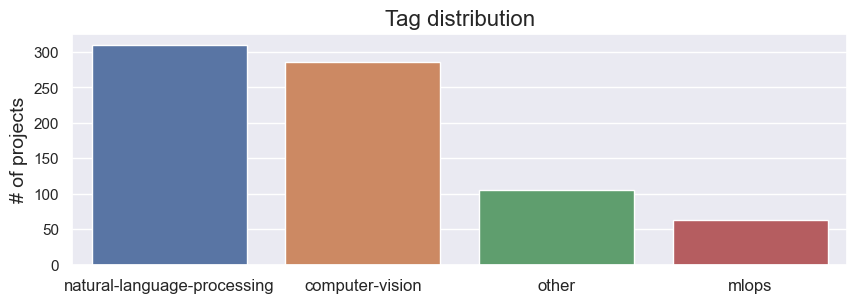

In [17]:
# Plot tag frequencies
tags, tag_counts = zip(*all_tags.most_common())
plt.figure(figsize=(10, 3))
ax = sns.barplot(x=list(tags), y=list(tag_counts))
ax.set_xticklabels(tags, rotation=0, fontsize=12)
plt.title("Tag distribution", fontsize=16)
plt.ylabel("# of projects", fontsize=14)
plt.show()

> We'll address the [data imbalance](https://madewithml.com/courses/mlops/baselines#data-imbalance) after splitting into our train split and prior to training our model.

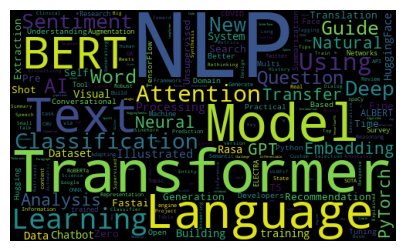

In [18]:
# Most frequent tokens for each tag
tag="natural-language-processing"
plt.figure(figsize=(10, 3))
subset = df[df.tag==tag]
text = subset.title.values
cloud = WordCloud(
    stopwords=STOPWORDS, background_color="black", collocations=False,
    width=500, height=300).generate(" ".join(text))
plt.axis("off")
plt.imshow(cloud)

Looks like the `title` text feature has some good signal for the respective classes and matches our intuition. We can repeat this for the `description` text feature as well. This information will become useful when we decide how to use our features for modeling.

## ✨ Data Preprocessing

Preprocessing the data via feature engineering, filtering and cleaning. Certain preprocessing steps are global (don't depend on our dataset, ex. lower casing text, removing stop words, etc.) and others are local (constructs are learned only from the training split, ex. vocabulary, standardization, etc.). For the local, dataset-dependent preprocessing steps, we want to ensure that we [split](https://madewithml.com/courses/mlops/splitting) the data first before preprocessing to avoid data leaks.

In [19]:
import json
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re

### Feature engineering

We can combine existing input features to create new meaningful signal (helping the model learn). 

In [20]:
# Feature engineering
df["text"] = df.title + " " + df.description

### Clean text

In [21]:
nltk.download("stopwords")
STOPWORDS = stopwords.words("english")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\JT\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [22]:
def clean_text(text, stopwords=STOPWORDS):
    """Clean raw text string."""
    # Lower
    text = text.lower()

    # Remove stopwords
    pattern = re.compile(r'\b(' + r"|".join(stopwords) + r")\b\s*")
    text = pattern.sub('', text)

    # Spacing and filters
    text = re.sub(r"([!\"'#$%&()*\+,-./:;<=>?@\\\[\]^_`{|}~])", r" \1 ", text)  # add spacing
    text = re.sub("[^A-Za-z0-9]+", " ", text)  # remove non alphanumeric chars
    text = re.sub(" +", " ", text)  # remove multiple spaces
    text = text.strip()  # strip white space at the ends
    text = re.sub(r"http\S+", "", text)  #  remove links
    
    return text

In [23]:
# Apply to dataframe
original_df = df.copy()
df.text = df.text.apply(clean_text)
print (f"{original_df.text.values[0]}\n{df.text.values[0]}")

Comparison between YOLO and RCNN on real world videos Bringing theory to experiment is cool. We can easily train models in colab and find the results in minutes.
comparison yolo rcnn real world videos bringing theory experiment cool easily train models colab find results minutes


### Clean DataFrame

In [24]:
# DataFrame cleanup
df = df.drop(columns=["id", "created_on", "title", "description"], errors="ignore")  # drop cols
df = df.dropna(subset=["tag"])  # drop nulls
df = df[["text", "tag"]]  # rearrange cols
df.head()

,text,tag
0,comparison yolo rcnn real world videos bringin...,computer-vision
1,show infer tell contextual inference creative ...,computer-vision
2,awesome graph classification collection import...,other
3,awesome monte carlo tree search curated list m...,other
4,attentionwalk pytorch implementation watch ste...,other


### Label encoding

In [25]:
# Label to index
tags = train_df.tag.unique().tolist()
num_classes = len(tags)
class_to_index = {tag: i for i, tag in enumerate(tags)}
class_to_index

{'mlops': 0,
 'natural-language-processing': 1,
 'computer-vision': 2,
 'other': 3}

In [26]:
# Encode labels
df["tag"] = df["tag"].map(class_to_index)
df.head()

,text,tag
0,comparison yolo rcnn real world videos bringin...,2
1,show infer tell contextual inference creative ...,2
2,awesome graph classification collection import...,3
3,awesome monte carlo tree search curated list m...,3
4,attentionwalk pytorch implementation watch ste...,3


In [27]:
def decode(indices, index_to_class):
    return [index_to_class[index] for index in indices]

In [28]:
index_to_class = {v:k for k, v in class_to_index.items()}
decode(df.head()["tag"].values, index_to_class=index_to_class)

['computer-vision', 'computer-vision', 'other', 'other', 'other']

### Tokenizer

In [29]:
import numpy as np
from transformers import BertTokenizer

In [30]:
# Bert tokenizer
tokenizer = BertTokenizer.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)
text = "Transfer learning with transformers for text classification."
encoded_inputs = tokenizer([text], return_tensors="np", padding="longest")  # pad to longest item in batch
print ("input_ids:", encoded_inputs["input_ids"])
print ("attention_mask:", encoded_inputs["attention_mask"])
print (tokenizer.decode(encoded_inputs["input_ids"][0]))

input_ids: [[  102  2268  1904   190 29155   168  3267  2998   205   103]]
attention_mask: [[1 1 1 1 1 1 1 1 1 1]]
[CLS] transfer learning with transformers for text classification. [SEP]


In [31]:
def tokenize(batch):
    tokenizer = BertTokenizer.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)
    encoded_inputs = tokenizer(batch["text"].tolist(), return_tensors="np", padding="longest")
    return dict(ids=encoded_inputs["input_ids"], masks=encoded_inputs["attention_mask"], targets=np.array(batch["tag"]))

In [33]:
def preprocess(df, class_to_index):
    """Preprocess the data."""
    df["text"] = df.title + " " + df.description  # feature engineering
    df["text"] = df.text.apply(clean_text)  # clean text
    df = df.drop(columns=["id", "created_on", "title", "description"], errors="ignore")  # clean dataframe
    df = df[["text", "tag"]]  # rearrange columns
    df["tag"] = df["tag"].map(class_to_index)  # label encoding
    outputs = tokenize(df)
    return outputs

### Distributed preprocessing

In [35]:
from madewithml.data import stratify_split
ray.data.DatasetContext.get_current().execution_options.preserve_order = True

In [36]:
# Data ingestion
ds = ray.data.read_csv(DATASET_LOC)
ds = ds.random_shuffle(seed=1234)
ds.take(1)

2024-05-26 10:07:32,699	INFO read_api.py:406 -- To satisfy the requested parallelism of 24, each read task output is split into 24 smaller blocks.
2024-05-26 10:07:32,729	INFO dataset.py:2380 -- Tip: Use `take_batch()` instead of `take() / show()` to return records in pandas or numpy batch format.
2024-05-26 10:07:32,732	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(24)] -> AllToAllOperator[RandomShuffle] -> LimitOperator[limit=1]
2024-05-26 10:07:32,732	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-05-26 10:07:32,732	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/576 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/576 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/576 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

[{'id': 695,
  'created_on': datetime.datetime(2020, 5, 2, 21, 33, 31),
  'title': 'Five Cool Python Libraries for Data Science',
  'description': 'Python is a best friend for the majority of the Data Scientists. Libraries make their life simpler. I have come across five cool Python libraries while working ',
  'tag': 'natural-language-processing'}]

In [37]:
# Split dataset
test_size = 0.2
train_ds, val_ds = stratify_split(ds, stratify="tag", test_size=test_size)

2024-05-26 10:07:35,649	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(24)] -> AllToAllOperator[RandomShuffle] -> LimitOperator[limit=1]
2024-05-26 10:07:35,649	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-05-26 10:07:35,649	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/576 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/576 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/576 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

In [38]:
# Mapping
tags = train_ds.unique(column="tag")
class_to_index = {tag: i for i, tag in enumerate(tags)}

2024-05-26 10:07:36,445	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(24)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> LimitOperator[limit=1]
2024-05-26 10:07:36,445	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-05-26 10:07:36,445	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/576 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/576 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/576 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/576 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/576 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/576 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/576 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/576 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/576 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/576 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/24 [00:00<?, ?it/s]

2024-05-26 10:07:39,111	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(24)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> AllToAllOperator[Aggregate] -> TaskPoolMapOperator[MapBatches(<lambda>)]
2024-05-26 10:07:39,111	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-05-26 10:07:39,111	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/576 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/576 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/576 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/576 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/576 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/576 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/576 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/576 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/576 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/576 [00:00<?, ?it/s]

- Aggregate 11:   0%|          | 0/576 [00:00<?, ?it/s]

Shuffle Map 12:   0%|          | 0/576 [00:00<?, ?it/s]

Shuffle Reduce 13:   0%|          | 0/576 [00:00<?, ?it/s]

Running 0:   0%|          | 0/576 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/24 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/24 [00:00<?, ?it/s]

In [39]:
# Distributed preprocessing
sample_ds = train_ds.map_batches(preprocess, fn_kwargs={"class_to_index": class_to_index}, batch_format="pandas")
sample_ds.show(1)

2024-05-26 10:07:40,837	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(24)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> TaskPoolMapOperator[MapBatches(preprocess)] -> LimitOperator[limit=1]
2024-05-26 10:07:40,837	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-05-26 10:07:40,837	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/576 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/576 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/576 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/576 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/576 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/576 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/576 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/576 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/576 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/576 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/24 [00:00<?, ?it/s]

{'ids': array([  102,   638, 30108,   453, 18205,  4631,  1904,   453, 18205,
        5560,  4631,  1904,  6283,  2117,  6773, 25644,  8855,  1519,
        1861,   103,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0]), 'masks': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'targets': 0}


# Training

When developing models, it's always a best practice to start with the simplest models and slowly motivate more complex models. For example our baseline model progression would be: 

1. random model (predict labels randomly)
2. rule-based model (pattern match labels in input text)
3. logistic regression (td-idf vectors from text)
4. CNN (apply character filters over text)
5. Fine-tune LLM (this notebook)

We cover all of these methods in our [other lessons](https://madewithml.com/#foundations) but since our focus here in on MLOps, we will skip directly to fine-tuning an LLM for our task.

We'll first set up some functions that will help us achieve complete reproducibility.

In [40]:
import os
import random
import torch
from ray.data.preprocessor import Preprocessor

In [41]:
def set_seeds(seed=42):
    """Set seeds for reproducibility."""
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    eval("setattr(torch.backends.cudnn, 'deterministic', True)")
    eval("setattr(torch.backends.cudnn, 'benchmark', False)")
    os.environ["PYTHONHASHSEED"] = str(seed)

In [42]:
def load_data(num_samples=None):
    ds = ray.data.read_csv(DATASET_LOC)
    ds = ds.random_shuffle(seed=1234)
    ds = ray.data.from_items(ds.take(num_samples)) if num_samples else ds
    return ds

In [43]:
class CustomPreprocessor():
    """Custom preprocessor class."""
    def __init__(self, class_to_index={}):
        self.class_to_index = class_to_index or {}  # mutable defaults
        self.index_to_class = {v: k for k, v in self.class_to_index.items()}
        
    def fit(self, ds):
        tags = ds.unique(column="tag")
        self.class_to_index = {tag: i for i, tag in enumerate(tags)}
        self.index_to_class = {v:k for k, v in self.class_to_index.items()}
        return self
    
    def transform(self, ds):
        return ds.map_batches(
            preprocess, 
            fn_kwargs={"class_to_index": self.class_to_index}, 
            batch_format="pandas")

## 🤖 Model

In [44]:
import torch.nn as nn
from transformers import BertModel

In [45]:
# Pretrained LLM
llm = BertModel.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)
embedding_dim = llm.config.hidden_size

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [46]:
# Sample
text = "Transfer learning with transformers for text classification."
batch = tokenizer([text], return_tensors="np", padding="longest")
batch = {k:torch.tensor(v) for k,v in batch.items()}  # convert to torch tensors
seq, pool = llm(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"])
np.shape(seq), np.shape(pool)

(torch.Size([1, 10, 768]), torch.Size([1, 768]))

In [47]:
class FinetunedLLM(nn.Module):
    def __init__(self, llm, dropout_p, embedding_dim, num_classes):
        super(FinetunedLLM, self).__init__()
        self.llm = llm
        self.dropout_p = dropout_p
        self.embedding_dim = embedding_dim
        self.num_classes = num_classes
        self.dropout = torch.nn.Dropout(dropout_p)
        self.fc1 = torch.nn.Linear(embedding_dim, num_classes)

    def forward(self, batch):
        ids, masks = batch["ids"], batch["masks"]
        seq, pool = self.llm(input_ids=ids, attention_mask=masks)
        z = self.dropout(pool)
        z = self.fc1(z)
        return z
    
    @torch.inference_mode()
    def predict(self, batch):
        self.eval()
        z = self(batch)
        y_pred = torch.argmax(z, dim=1).cpu().numpy()
        return y_pred
    
    @torch.inference_mode()
    def predict_proba(self, batch):
        self.eval()
        z = self(batch)
        y_probs = F.softmax(z, dim=1).cpu().numpy()
        return y_probs
    
    def save(self, dp):
        with open(Path(dp, "args.json"), "w") as fp:
            contents = {
                "dropout_p": self.dropout_p,
                "embedding_dim": self.embedding_dim,
                "num_classes": self.num_classes,
            }
            json.dump(contents, fp, indent=4, sort_keys=False)
        torch.save(self.state_dict(), os.path.join(dp, "model.pt"))

    @classmethod
    def load(cls, args_fp, state_dict_fp):
        with open(args_fp, "r") as fp:
            kwargs = json.load(fp=fp)
        llm = BertModel.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)
        model = cls(llm=llm, **kwargs)
        model.load_state_dict(torch.load(state_dict_fp, map_location=torch.device("cpu")))
        return model

In [48]:
# Initialize model
model = FinetunedLLM(llm=llm, dropout_p=0.5, embedding_dim=embedding_dim, num_classes=num_classes)
print (model.named_parameters)

<bound method Module.named_parameters of FinetunedLLM(
  (llm): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31090, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): Layer

## 📦 Batching

We can iterate through our dataset in batches however we may have batches of different sizes. Recall that our tokenizer padded the inputs to the longest item in the batch (`padding="longest"`). However, our batches for training will be smaller than our large data processing batches and so our batches here may have inputs with different lengths. To address this, we're going to define a custom `collate_fn` to repad the items in our training batches.

In [49]:
from ray.train.torch import get_device

In [50]:
def pad_array(arr, dtype=np.int32):
    max_len = max(len(row) for row in arr)
    padded_arr = np.zeros((arr.shape[0], max_len), dtype=dtype)
    for i, row in enumerate(arr):
        padded_arr[i][:len(row)] = row
    return padded_arr

In [51]:
def collate_fn(batch):
    batch["ids"] = pad_array(batch["ids"])
    batch["masks"] = pad_array(batch["masks"])
    dtypes = {"ids": torch.int32, "masks": torch.int32, "targets": torch.int64}
    tensor_batch = {}
    for key, array in batch.items():
        tensor_batch[key] = torch.as_tensor(array, dtype=dtypes[key], device=get_device())
    return tensor_batch

> `pad=(0, max_len)` in [F.pad](https://pytorch.org/docs/stable/generated/torch.nn.functional.pad.html#torch-nn-functional-pad) refers to (left_padding, right_padding) on the input. There will be no left-padding (hence the `0`) and only right-padding. And the `constant` mode refers to each element being padded to a constant size (size of longest element in the input).

In [52]:
# Sample batch
sample_batch = sample_ds.take_batch(batch_size=128)
collate_fn(batch=sample_batch)

2024-05-26 10:07:50,282	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(24)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> TaskPoolMapOperator[MapBatches(preprocess)] -> LimitOperator[limit=128]
2024-05-26 10:07:50,282	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-05-26 10:07:50,282	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/576 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/576 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/576 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/576 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/576 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/576 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/576 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/576 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/576 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/576 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/24 [00:00<?, ?it/s]

{'ids': tensor([[  102,   638, 30108,  ...,     0,     0,     0],
         [  102, 11448, 20591,  ...,     0,     0,     0],
         [  102, 13564,  1995,  ...,     0,     0,     0],
         ...,
         [  102, 18403, 30114,  ...,     0,     0,     0],
         [  102,  2567,  1995,  ...,     0,     0,     0],
         [  102,   239, 30118,  ..., 24660, 30131,   103]], dtype=torch.int32),
 'masks': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 1, 1, 1]], dtype=torch.int32),
 'targets': tensor([0, 0, 3, 0, 0, 0, 2, 1, 2, 2, 0, 3, 3, 0, 0, 2, 2, 2, 1, 0, 2, 3, 2, 1,
         2, 0, 2, 2, 0, 0, 3, 0, 0, 0, 2, 1, 2, 2, 0, 3, 3, 0, 0, 2, 2, 2, 1, 0,
         2, 3, 2, 1, 2, 0, 2, 2, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 2, 3, 2, 3, 2, 2,
         2, 0, 2, 3, 2, 3, 0, 2, 2, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 1, 2, 2,
         2, 1, 

## 🧮 Utilities

In [53]:
from pathlib import Path
import ray.train as train
from ray.train import Checkpoint, CheckpointConfig, DataConfig, RunConfig, ScalingConfig
from ray.train.torch import TorchCheckpoint, TorchTrainer
import tempfile
import torch.nn.functional as F
from torch.nn.parallel.distributed import DistributedDataParallel

In [54]:
def train_step(ds, batch_size, model, num_classes, loss_fn, optimizer):
    """Train step."""
    model.train()
    loss = 0.0
    ds_generator = ds.iter_torch_batches(batch_size=batch_size, collate_fn=collate_fn)
    for i, batch in enumerate(ds_generator):
        optimizer.zero_grad()  # reset gradients
        z = model(batch)  # forward pass
        targets = F.one_hot(batch["targets"], num_classes=num_classes).float()  # one-hot (for loss_fn)
        J = loss_fn(z, targets)  # define loss
        J.backward()  # backward pass
        optimizer.step()  # update weights
        loss += (J.detach().item() - loss) / (i + 1)  # cumulative loss
    return loss

In [55]:
def eval_step(ds, batch_size, model, num_classes, loss_fn):
    """Eval step."""
    model.eval()
    loss = 0.0
    y_trues, y_preds = [], []
    ds_generator = ds.iter_torch_batches(batch_size=batch_size, collate_fn=collate_fn)
    with torch.inference_mode():
        for i, batch in enumerate(ds_generator):
            z = model(batch)
            targets = F.one_hot(batch["targets"], num_classes=num_classes).float()  # one-hot (for loss_fn)
            J = loss_fn(z, targets).item()
            loss += (J - loss) / (i + 1)
            y_trues.extend(batch["targets"].cpu().numpy())
            y_preds.extend(torch.argmax(z, dim=1).cpu().numpy())
    return loss, np.vstack(y_trues), np.vstack(y_preds)

In [56]:
# Training loop
def train_loop_per_worker(config):
    # Hyperparameters
    dropout_p = config["dropout_p"]
    lr = config["lr"]
    lr_factor = config["lr_factor"]
    lr_patience = config["lr_patience"]
    num_epochs = config["num_epochs"]
    batch_size = config["batch_size"]
    num_classes = config["num_classes"]

    # Get datasets
    set_seeds()
    train_ds = train.get_dataset_shard("train")
    val_ds = train.get_dataset_shard("val")

    # Model
    llm = BertModel.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)
    model = FinetunedLLM(llm=llm, dropout_p=dropout_p, embedding_dim=llm.config.hidden_size, num_classes=num_classes)
    model = train.torch.prepare_model(model)

    # Training components
    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=lr_factor, patience=lr_patience)

    # Training
    num_workers = train.get_context().get_world_size()
    batch_size_per_worker = batch_size // num_workers
    for epoch in range(num_epochs):
        # Step
        train_loss = train_step(train_ds, batch_size_per_worker, model, num_classes, loss_fn, optimizer)
        val_loss, _, _ = eval_step(val_ds, batch_size_per_worker, model, num_classes, loss_fn)
        scheduler.step(val_loss)

        # Checkpoint
        with tempfile.TemporaryDirectory() as dp:
            if isinstance(model, DistributedDataParallel):  # cpu
                model.module.save(dp=dp)
            else:
                model.save(dp=dp)
            metrics = dict(epoch=epoch, lr=optimizer.param_groups[0]["lr"], train_loss=train_loss, val_loss=val_loss)
            checkpoint = Checkpoint.from_directory(dp)
            train.report(metrics, checkpoint=checkpoint)

Our dataset doesn't suffer from horrible class imbalance, but if it did, we could easily account for it through our loss function. There are also other strategies such as [over-sampling](https://imbalanced-learn.org/stable/over_sampling.html) less frequent classes and [under-sampling](https://imbalanced-learn.org/stable/under_sampling.html) popular classes.

```python
# Class weights
batch_counts = []
for batch in train_ds.iter_torch_batches(batch_size=256, collate_fn=collate_fn):
    batch_counts.append(np.bincount(batch["targets"].cpu().numpy()))
counts = [sum(count) for count in zip(*batch_counts)]
class_weights = np.array([1.0/count for i, count in enumerate(counts)])
class_weights_tensor = torch.Tensor(class_weights).to(get_device())

# Training components
loss_fn = nn.BCEWithLogitsLoss(weight=class_weights_tensor)
...
```

## 🗂️ Configurations

In [65]:
# Train loop config
train_loop_config = {
    "dropout_p": 0.5,
    "lr": 1e-4,
    "lr_factor": 0.8,
    "lr_patience": 3,
    "num_epochs": 1,
    "batch_size": 32,
    "num_classes": num_classes,
}

In [66]:
# Scaling config
scaling_config = ScalingConfig(
    num_workers=num_workers,
    use_gpu=bool(resources_per_worker["GPU"]),
    resources_per_worker=resources_per_worker
)

In [67]:
# Run config
checkpoint_config = CheckpointConfig(num_to_keep=1, checkpoint_score_attribute="val_loss", checkpoint_score_order="min")
run_config = RunConfig(name="llm", checkpoint_config=checkpoint_config, storage_path="file:///c/Users/JT/ray_results/")

## 🚂 Training

In [68]:
# Dataset
ds = load_data()
train_ds, val_ds = stratify_split(ds, stratify="tag", test_size=test_size)

2024-05-26 10:09:06,614	INFO read_api.py:406 -- To satisfy the requested parallelism of 24, each read task output is split into 24 smaller blocks.
2024-05-26 10:09:06,614	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(24)] -> AllToAllOperator[RandomShuffle] -> LimitOperator[limit=1]
2024-05-26 10:09:06,614	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-05-26 10:09:06,614	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/576 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/576 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/576 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

In [69]:
# Preprocess
preprocessor = CustomPreprocessor()
preprocessor =  preprocessor.fit(train_ds)
train_ds = preprocessor.transform(train_ds)
val_ds = preprocessor.transform(val_ds)
train_ds = train_ds.materialize()
val_ds = val_ds.materialize()

2024-05-26 10:09:08,520	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(24)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> LimitOperator[limit=1]
2024-05-26 10:09:08,521	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-05-26 10:09:08,521	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/576 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/576 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/576 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/576 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/576 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/576 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/576 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/576 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/576 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/576 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/24 [00:00<?, ?it/s]

2024-05-26 10:09:10,196	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(24)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> AllToAllOperator[Aggregate] -> TaskPoolMapOperator[MapBatches(<lambda>)]
2024-05-26 10:09:10,199	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-05-26 10:09:10,199	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/576 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/576 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/576 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/576 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/576 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/576 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/576 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/576 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/576 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/576 [00:00<?, ?it/s]

- Aggregate 11:   0%|          | 0/576 [00:00<?, ?it/s]

Shuffle Map 12:   0%|          | 0/576 [00:00<?, ?it/s]

Shuffle Reduce 13:   0%|          | 0/576 [00:00<?, ?it/s]

Running 0:   0%|          | 0/576 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/24 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/24 [00:00<?, ?it/s]

2024-05-26 10:09:11,971	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(24)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> TaskPoolMapOperator[MapBatches(preprocess)]
2024-05-26 10:09:11,971	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-05-26 10:09:11,971	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/576 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/576 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/576 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/576 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/576 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/576 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/576 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/576 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/576 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/576 [00:00<?, ?it/s]

Running 0:   0%|          | 0/576 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/24 [00:00<?, ?it/s]

2024-05-26 10:09:14,977	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(24)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> TaskPoolMapOperator[MapBatches(preprocess)]
2024-05-26 10:09:14,977	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-05-26 10:09:14,977	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/576 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/576 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/576 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/576 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/576 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/576 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/576 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/576 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/576 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/576 [00:00<?, ?it/s]

Running 0:   0%|          | 0/576 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/24 [00:00<?, ?it/s]

In [70]:
# Dataset config
options = ray.data.ExecutionOptions(preserve_order=True)
dataset_config = DataConfig(
    datasets_to_split=["train"],
    execution_options=options)

In [71]:
# Trainer
trainer = TorchTrainer(
    train_loop_per_worker=train_loop_per_worker,
    train_loop_config=train_loop_config,
    scaling_config=scaling_config,
    run_config=run_config,
    datasets={"train": train_ds, "val": val_ds},
    dataset_config=dataset_config,
    metadata={"class_to_index": preprocessor.class_to_index}
)

In [72]:
trainer.get_dataset_config

<bound method DataParallelTrainer.get_dataset_config of <TorchTrainer scaling_config=ScalingConfig(num_workers=1, resources_per_worker={'CPU': 1, 'GPU': 0}) run_config=RunConfig(name='llm', storage_path='file:///c/Users/JT/ray_results/', checkpoint_config=CheckpointConfig(num_to_keep=1, checkpoint_score_attribute='val_loss', checkpoint_score_order='min'), verbose=1) datasets={'train': MaterializedDataset(
   num_blocks=24,
   num_rows=610,
   schema={
      ids: numpy.ndarray(ndim=1, dtype=int32),
      masks: numpy.ndarray(ndim=1, dtype=int32),
      targets: int64
   }
), 'val': MaterializedDataset(
   num_blocks=24,
   num_rows=154,
   schema={
      ids: numpy.ndarray(ndim=1, dtype=int32),
      masks: numpy.ndarray(ndim=1, dtype=int32),
      targets: int64
   }
)}>>

In [73]:
%%time
# Train
results = trainer.fit()

(pid=19480) Running 0:   0%|          | 0/24 [00:00<?, ?it/s]

2024-05-26 10:14:29,375	WARNING syncer.py:458 -- Last sync command failed with the following error:
Traceback (most recent call last):
  File "C:\Users\JT\Documents\repos\madewithml\venv\lib\site-packages\ray\train\_internal\syncer.py", line 456, in _launch_sync_process
    self.wait()
  File "C:\Users\JT\Documents\repos\madewithml\venv\lib\site-packages\ray\train\_internal\syncer.py", line 530, in wait
    raise e
  File "C:\Users\JT\Documents\repos\madewithml\venv\lib\site-packages\ray\train\_internal\syncer.py", line 528, in wait
    self._sync_process.wait(timeout=self.sync_timeout)
  File "C:\Users\JT\Documents\repos\madewithml\venv\lib\site-packages\ray\train\_internal\syncer.py", line 203, in wait
    raise exception
  File "C:\Users\JT\Documents\repos\madewithml\venv\lib\site-packages\ray\train\_internal\syncer.py", line 166, in entrypoint
    result = self._fn(*args, **kwargs)
  File "C:\Users\JT\Documents\repos\madewithml\venv\lib\site-packages\ray\train\_internal\storage.py"

ValueError: No experiment checkpoint file of form 'experiment_state-*.json' was found at: (local, /c/Users/JT/ray_results/llm)
Please check if you specified the correct experiment path, which should be a combination of the `storage_path` and `name` specified in your run.

In [84]:
# Metrics per epoch
results.metrics_dataframe

NameError: name 'results' is not defined

In [ ]:
# Best checkpoints
results.best_checkpoints